In [25]:
pip install ptflops

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Write your code here.
%pip install tensorflow

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as K

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.36 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.2.2+cu118 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [28]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [30]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


In [31]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)


In [32]:
def depthwise_separable_conv(x, filters, kernel_size=(3, 3)):
    x = layers.DepthwiseConv2D(kernel_size, padding='same')(x)
    x = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    return x

In [33]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = depthwise_separable_conv(x1, growth_rate, kernel_size=(3, 3))
        x = layers.Concatenate()([x, x1])
    return x


In [34]:
def transition_layer(x, compression_factor=0.5):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    num_filters = int(x.shape[-1] * compression_factor)
    x = depthwise_separable_conv(x, num_filters, kernel_size=(1, 1))
    x = layers.AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x


In [35]:
def build_ds_cnn(input_shape=(32, 32, 3), num_classes=10, growth_rate=12, compression_factor=0.5):
    inputs = layers.Input(shape=input_shape)
    x = depthwise_separable_conv(inputs, 16, kernel_size=(3, 3))
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x, compression_factor)
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x, compression_factor)
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = transition_layer(x, compression_factor)
    x = dense_block(x, num_layers=4, growth_rate=growth_rate)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)


In [36]:
def build_baseline_cnn(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)


In [37]:
ds_cnn = build_ds_cnn()
baseline_cnn = build_baseline_cnn()


In [38]:
print("Depth-wise Separable CNN Summary:")
ds_cnn.summary()
print("\nBaseline CNN Summary:")
baseline_cnn.summary()


Depth-wise Separable CNN Summary:
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 depthwise_conv2d_20 (Depth  (None, 32, 32, 3)            30        ['input_3[0][0]']             
 wiseConv2D)                                                                                      
                                                                                                  
 conv2d_22 (Conv2D)          (None, 32, 32, 16)           64        ['depthwise_conv2d_20[0][0]'] 
                                                                                                  
 batch_normalization_22 (Ba  (None, 32, 32, 16)           

In [39]:
ds_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]


In [41]:
start_time = time.time()
ds_history = ds_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)
ds_training_time = time.time() - start_time


Epoch 1/100
704/704 [==============================] - ETA: 0s - loss: 1.6161 - accuracy: 0.3964

/home/dc_gr1/miniconda3/envs/test/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 228s 313ms/step - loss: 1.6161 - accuracy: 0.3964 - val_loss: 1.9139 - val_accuracy: 0.3598 - lr: 0.0010
Epoch 2/100
704/704 [==============================] - 219s 311ms/step - loss: 1.2430 - accuracy: 0.5478 - val_loss: 1.5063 - val_accuracy: 0.4790 - lr: 0.0010
Epoch 3/100
704/704 [==============================] - 217s 308ms/step - loss: 1.0999 - accuracy: 0.6057 - val_loss: 1.5524 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 4/100
704/704 [==============================] - 216s 307ms/step - loss: 1.0102 - accuracy: 0.6388 - val_loss: 1.3653 - val_accuracy: 0.5372 - lr: 0.0010
Epoch 5/100
704/704 [==============================] - 217s 307ms/step - loss: 0.9460 - accuracy: 0.6638 - val_loss: 1.0662 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 6/100
704/704 [==============================] - 215s 305ms/step - loss: 0.8917 - accuracy: 0.6846 - val_loss: 1.0895 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 7/100
704/704 [==============================]

In [42]:
start_time = time.time()
baseline_history = baseline_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)
baseline_training_time = time.time() - start_time


Epoch 1/100
704/704 [==============================] - 45s 63ms/step - loss: 1.8049 - accuracy: 0.3521 - val_loss: 1.7861 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 2/100
704/704 [==============================] - 41s 59ms/step - loss: 1.6152 - accuracy: 0.4201 - val_loss: 1.9208 - val_accuracy: 0.3626 - lr: 0.0010
Epoch 3/100
704/704 [==============================] - 43s 61ms/step - loss: 1.5344 - accuracy: 0.4511 - val_loss: 1.7888 - val_accuracy: 0.3940 - lr: 0.0010
Epoch 4/100
704/704 [==============================] - 41s 58ms/step - loss: 1.4844 - accuracy: 0.4714 - val_loss: 2.1748 - val_accuracy: 0.3660 - lr: 0.0010
Epoch 5/100
704/704 [==============================] - 42s 59ms/step - loss: 1.4446 - accuracy: 0.4868 - val_loss: 1.5682 - val_accuracy: 0.4328 - lr: 0.0010
Epoch 6/100
704/704 [==============================] - 43s 61ms/step - loss: 1.4121 - accuracy: 0.5010 - val_loss: 1.4667 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 7/100
704/704 [==============================]

In [43]:
def evaluate_model(model, x_test, y_test):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = model.predict(x_test)
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
    y_true_classes = tf.argmax(y_test, axis=1).numpy()

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    ]))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall:    {recall:.4f}")
    print(f"Weighted F1 Score:  {f1:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))
    return test_loss, test_accuracy


In [44]:
print("\nDepth-wise Separable CNN Evaluation:")
ds_test_loss, ds_test_accuracy = evaluate_model(ds_cnn, x_test, y_test)
print("\nBaseline CNN Evaluation:")
baseline_test_loss, baseline_test_accuracy = evaluate_model(baseline_cnn, x_test, y_test)



Depth-wise Separable CNN Evaluation:
313/313 [==============================] - 15s 46ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.79      0.79      1000
  automobile       0.90      0.91      0.90      1000
        bird       0.68      0.68      0.68      1000
         cat       0.71      0.53      0.60      1000
        deer       0.76      0.75      0.75      1000
         dog       0.78      0.57      0.66      1000
        frog       0.67      0.91      0.77      1000
       horse       0.82      0.83      0.83      1000
        ship       0.87      0.89      0.88      1000
       truck       0.81      0.91      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000

Weighted Precision: 0.7781
Weighted Recall:    0.7769
Weighted F1 Score:  0.7725
Confusion Matrix:
[[791  14  47   5  20   

In [45]:
def calculate_flops(model, input_shape=(32, 32, 3)):
    inputs = tf.random.normal([1] + list(input_shape))

    from tensorflow.keras import backend as K
    graph = tf.compat.v1.get_default_graph()
    with graph.as_default():
        K.set_learning_phase(0)
        flops = tf.compat.v1.profiler.profile(
            graph,
            options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        ).total_float_ops
    return flops


In [46]:
print("\nComputational Efficiency:")
ds_flops = calculate_flops(ds_cnn)
baseline_flops = calculate_flops(baseline_cnn)
print(f"Depth-wise Separable CNN FLOPs: {ds_flops}")
print(f"Baseline CNN FLOPs:             {baseline_flops}")
print(f"\nDepth-wise Separable CNN Training Time: {ds_training_time:.2f}s")
print(f"Baseline CNN Training Time:             {baseline_training_time:.2f}s")



Computational Efficiency:

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for

/home/dc_gr1/miniconda3/envs/test/lib/python3.8/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

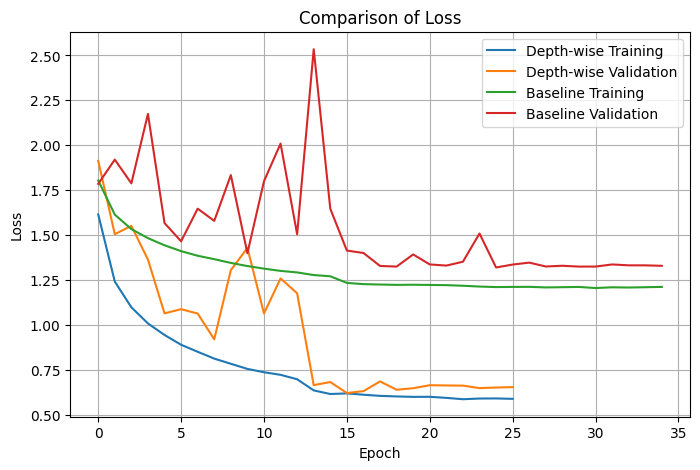

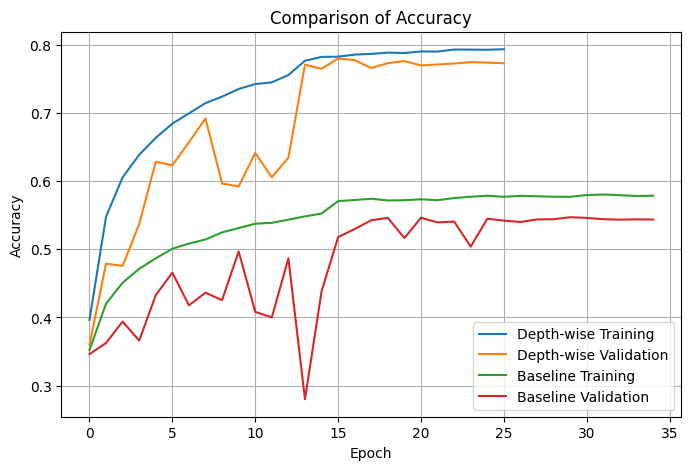

In [47]:
def plot_curves(history1, history2, label1, label2, metric):
    plt.figure(figsize=(8, 5))
    plt.plot(history1.history[metric], label=f'{label1} Training')
    plt.plot(history1.history[f'val_{metric}'], label=f'{label1} Validation')
    plt.plot(history2.history[metric], label=f'{label2} Training')
    plt.plot(history2.history[f'val_{metric}'], label=f'{label2} Validation')
    plt.title(f'Comparison of {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curves(ds_history, baseline_history, 'Depth-wise', 'Baseline', 'loss')
plot_curves(ds_history, baseline_history, 'Depth-wise', 'Baseline', 'accuracy')